# Research Question 8

8. How do healthcare access and quality compare in each state, including the number of hospitals and health insurance coverage rates?

## Milestone 2

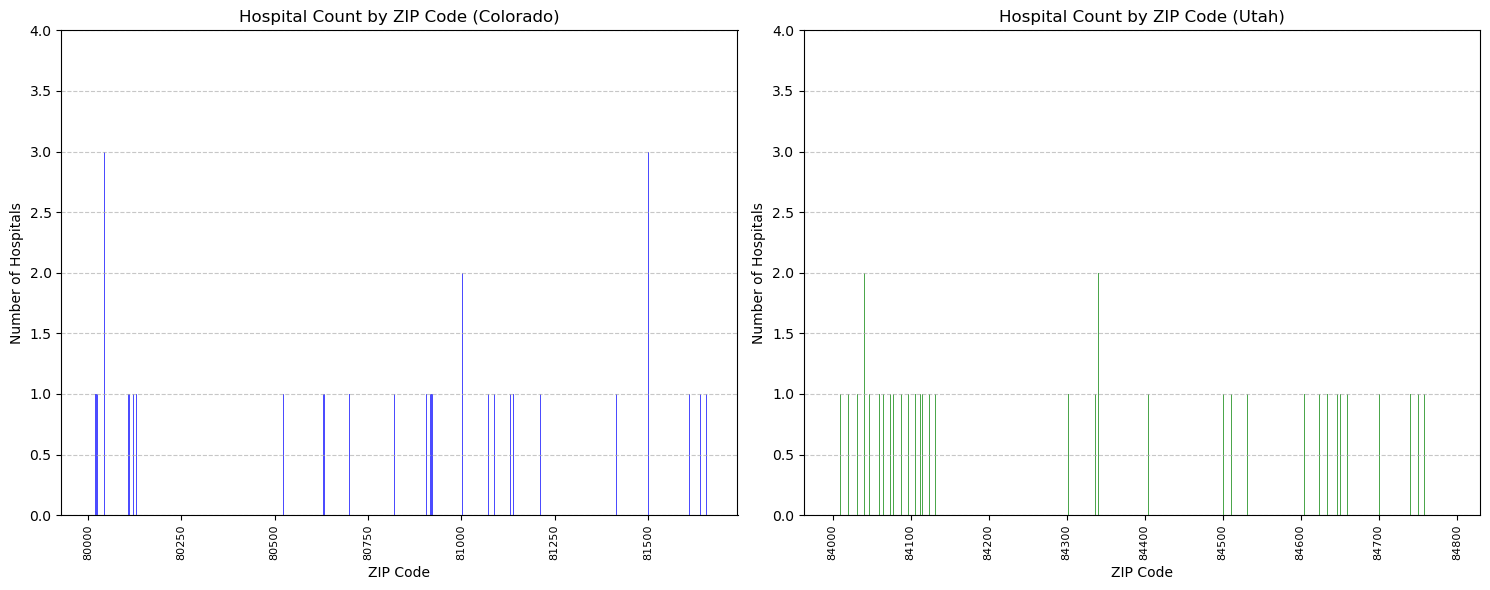

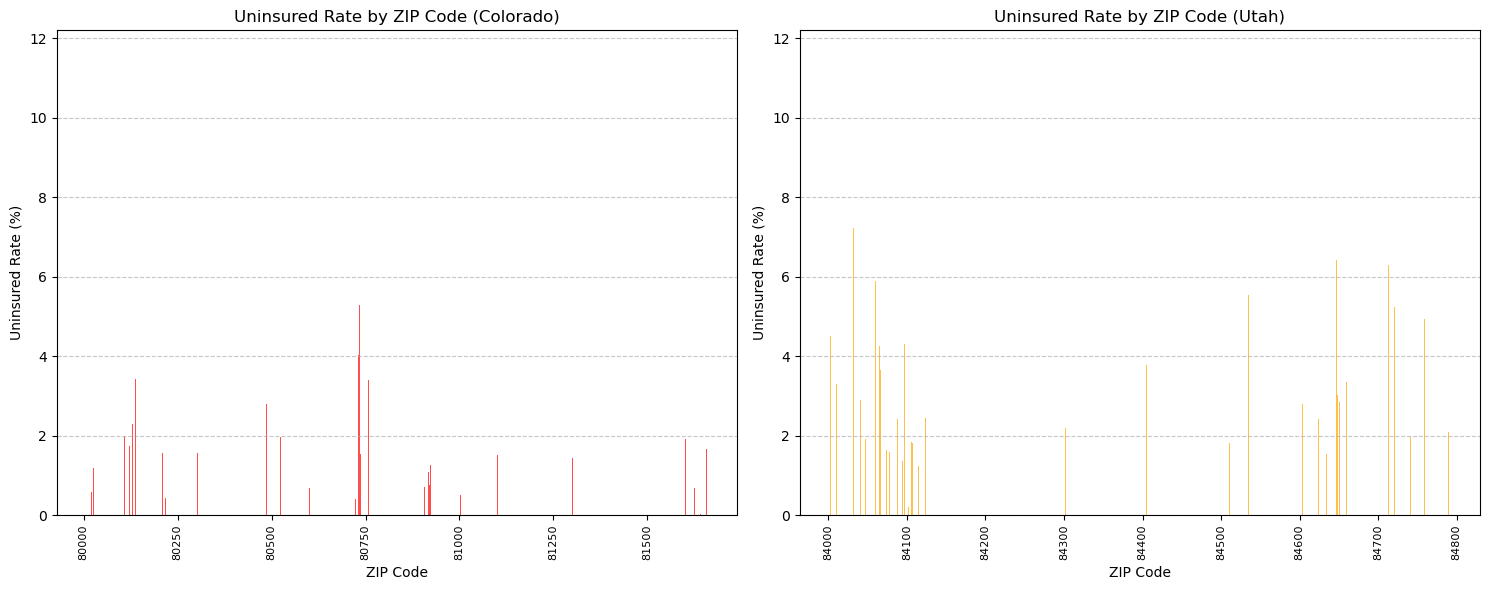

Maps saved: ../results/question_8/interactive_hospital_map.html and ../results/question_8/interactive_uninsured_map.html


In [1]:
import os
from IPython.display import display
import requests
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from io import StringIO
import pgeocode

# Ensure results directory exists
output_dir = "../results/question_8"
os.makedirs(output_dir, exist_ok=True)

### 1. Fetch Hospital Data ###
def get_hospital_data():
    url = 'https://data.cms.gov/provider-data/api/1/datastore/query/xubh-q36u/0/download?format=csv'
    response = requests.get(url)

    if response.status_code == 200:
        csv_data = StringIO(response.text)
        df = pd.read_csv(csv_data)
    else:
        print(f"Error fetching CMS data, Status Code: {response.status_code}")
        return None

    raw_data = df

    df["State"] = df["State"].astype(str).str.upper()
    df = df.dropna(subset=["ZIP Code"])
    df["ZIP Code"] = df["ZIP Code"].astype(str).str.extract(r"(\d+)").astype(float).astype("Int64")
    df = df[df["State"].isin(["CO", "UT"])]

    hospital_count = df.groupby(["State", "ZIP Code"])["Facility ID"].count().reset_index()
    hospital_count.columns = ["State", "ZIP_Code", "Hospital_Count"]

    return raw_data, hospital_count

### 2. Fetch Health Insurance Coverage Data ###
def get_health_insurance_data(year=2022):
    url = f"https://api.census.gov/data/{year}/acs/acs5?get=NAME,B27010_001E,B27010_005E&for=zip code tabulation area:*"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        df = pd.DataFrame(data[1:], columns=data[0])

        raw_data = df

        df["Total_Population"] = df["B27010_001E"].astype(int)
        df["Uninsured_Population"] = df["B27010_005E"].astype(int)
        df["Uninsured_Rate"] = df["Uninsured_Population"] / df["Total_Population"] * 100

        df.rename(columns={"zip code tabulation area": "ZIP_Code"}, inplace=True)
        df = df[df["ZIP_Code"].astype(int).between(80000, 81699) | df["ZIP_Code"].astype(int).between(84000, 84799)]

        return raw_data, df[["ZIP_Code", "Uninsured_Rate"]]
    else:
        print(f"Error fetching ACS data, Status Code: {response.status_code}")
        return None

### 3. Convert ZIP Codes to Latitude/Longitude ###
def get_lat_lon(zip_code):
    nomi = pgeocode.Nominatim("us")
    location = nomi.query_postal_code(str(zip_code))

    if pd.notna(location.latitude) and pd.notna(location.longitude):
        return location.latitude, location.longitude
    return None, None

### 4. Process and Merge Data ###
before_hospital_data, hospital_data = get_hospital_data()
before_health_insurance_data, health_insurance_data = get_health_insurance_data()

if hospital_data is not None and health_insurance_data is not None:
    hospital_data["ZIP_Code"] = hospital_data["ZIP_Code"].astype(int)
    health_insurance_data["ZIP_Code"] = health_insurance_data["ZIP_Code"].astype(int)

    merged_data = pd.merge(hospital_data, health_insurance_data, on="ZIP_Code", how="outer").fillna(0)
    merged_data = merged_data.sort_values(by="ZIP_Code")

    # Separate data for Colorado (CO) and Utah (UT)
    merged_data_CO = merged_data[merged_data["State"] == "CO"]
    merged_data_UT = merged_data[merged_data["State"] == "UT"]

    # Get maximum values to standardize y-axis scale
    max_hospitals = max(merged_data_CO["Hospital_Count"].max(), merged_data_UT["Hospital_Count"].max())
    max_uninsured = max(merged_data_CO["Uninsured_Rate"].max(), merged_data_UT["Uninsured_Rate"].max())

    ### 5. Generate Bar Graphs ###
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Colorado - Hospital Count
    axes[0].bar(merged_data_CO["ZIP_Code"], merged_data_CO["Hospital_Count"], color='b', alpha=0.7)
    axes[0].set_xlabel("ZIP Code")
    axes[0].set_ylabel("Number of Hospitals")
    axes[0].set_title("Hospital Count by ZIP Code (Colorado)")
    axes[0].tick_params(axis='x', rotation=90, labelsize=8)
    axes[0].grid(axis='y', linestyle="--", alpha=0.7)
    axes[0].set_ylim(0, max_hospitals + 1)

    # Utah - Hospital Count
    axes[1].bar(merged_data_UT["ZIP_Code"], merged_data_UT["Hospital_Count"], color='g', alpha=0.7)
    axes[1].set_xlabel("ZIP Code")
    axes[1].set_ylabel("Number of Hospitals")
    axes[1].set_title("Hospital Count by ZIP Code (Utah)")
    axes[1].tick_params(axis='x', rotation=90, labelsize=8)
    axes[1].grid(axis='y', linestyle="--", alpha=0.7)
    axes[1].set_ylim(0, max_hospitals + 1)

    # Save hospital count graph
    plt.tight_layout()
    plt.savefig(f"{output_dir}/hospital_count_graph.png")
    plt.show()
    plt.close('all')

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Colorado - Uninsured Rate
    axes[0].bar(merged_data_CO["ZIP_Code"], merged_data_CO["Uninsured_Rate"], color='r', alpha=0.7)
    axes[0].set_xlabel("ZIP Code")
    axes[0].set_ylabel("Uninsured Rate (%)")
    axes[0].set_title("Uninsured Rate by ZIP Code (Colorado)")
    axes[0].tick_params(axis='x', rotation=90, labelsize=8)
    axes[0].grid(axis='y', linestyle="--", alpha=0.7)
    axes[0].set_ylim(0, max_uninsured + 1)

    # Utah - Uninsured Rate
    axes[1].bar(merged_data_UT["ZIP_Code"], merged_data_UT["Uninsured_Rate"], color='orange', alpha=0.7)
    axes[1].set_xlabel("ZIP Code")
    axes[1].set_ylabel("Uninsured Rate (%)")
    axes[1].set_title("Uninsured Rate by ZIP Code (Utah)")
    axes[1].tick_params(axis='x', rotation=90, labelsize=8)
    axes[1].grid(axis='y', linestyle="--", alpha=0.7)
    axes[1].set_ylim(0, max_uninsured + 1)

    # Save uninsured rate graph
    plt.tight_layout()
    plt.savefig(f"{output_dir}/uninsured_rate_graph.png")
    plt.show()
    plt.close('all')

    # Convert ZIP codes to latitude and longitude
    merged_data["Latitude"], merged_data["Longitude"] = zip(*merged_data["ZIP_Code"].apply(get_lat_lon))
    merged_data = merged_data.dropna(subset=["Latitude", "Longitude"])

    ### 6. Generate Interactive Hospital Count Map ###
    map_hospitals = folium.Map(location=[39.5, -106.0], zoom_start=6, tiles="CartoDB positron")
    hospital_cluster = MarkerCluster().add_to(map_hospitals)

    for _, row in merged_data.iterrows():
        popup_info = f"""
        <b>ZIP Code:</b> {row['ZIP_Code']}<br>
        <b>Hospitals:</b> {row['Hospital_Count']}
        """

        folium.Marker(
            location=[row["Latitude"], row["Longitude"]],
            icon=folium.DivIcon(html=f'''
                <div style="
                    font-size: 10pt; 
                    color: white; 
                    background: blue; 
                    padding: 3px; 
                    border-radius: 5px;
                    text-align: center;
                    font-weight: bold;">
                    {row["Hospital_Count"]}
                </div>'''),
            popup=popup_info
        ).add_to(hospital_cluster)

    ### 7. Generate Interactive Uninsured Rate Map ###
    map_uninsured = folium.Map(location=[39.5, -106.0], zoom_start=6, tiles="CartoDB positron")
    uninsured_cluster = MarkerCluster().add_to(map_uninsured)

    for _, row in merged_data.iterrows():
        popup_info = f"""
        <b>ZIP Code:</b> {row['ZIP_Code']}<br>
        <b>Uninsured Rate:</b> {row['Uninsured_Rate']:.1f}%
        """

        folium.Marker(
            location=[row["Latitude"], row["Longitude"]],
            icon=folium.DivIcon(html=f'''
                <div style="
                    font-size: 10pt; 
                    color: white; 
                    background: red; 
                    padding: 3px; 
                    border-radius: 5px;
                    text-align: center;
                    font-weight: bold;">
                    {row["Uninsured_Rate"]:.1f}%
                </div>'''),
            popup=popup_info
        ).add_to(uninsured_cluster)

    # Save maps
    map_hospitals.save(f"{output_dir}/interactive_hospital_map.html")
    map_uninsured.save(f"{output_dir}/interactive_uninsured_map.html")

    print(f"Maps saved: {output_dir}/interactive_hospital_map.html and {output_dir}/interactive_uninsured_map.html")

### Before and After Snapshots of the Dataset

#### Hospital Data (before)

In [2]:
# before cleaning hosptial data
before_hospital_data.head()

,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Telephone Number,Hospital Type,Hospital Ownership,...,Count of READM Measures Better,Count of READM Measures No Different,Count of READM Measures Worse,READM Group Footnote,Pt Exp Group Measure Count,Count of Facility Pt Exp Measures,Pt Exp Group Footnote,TE Group Measure Count,Count of Facility TE Measures,TE Group Footnote
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,...,1,8,2,NaN,8,8,NaN,12,10,NaN
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,...,0,8,1,NaN,8,8,NaN,12,12,NaN
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 629-1000,Acute Care Hospitals,Proprietary,...,0,7,2,NaN,8,8,NaN,12,11,NaN
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,...,0,7,0,NaN,8,8,NaN,12,7,NaN
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,...,0,2,0,NaN,8,Not Available,5.0,12,6,NaN


In [3]:
# summarizing before cleaning hosptial data
before_hospital_data.describe()

,ZIP Code,MORT Group Footnote,Safety Group Footnote,READM Group Footnote,Pt Exp Group Footnote,TE Group Footnote
count,5396.000000,1869.000000,1990.000000,1081.000000,2189.000000,887.000000
mean,53752.226464,11.012841,10.665327,15.345976,10.109182,17.608794
std,27117.227313,7.002894,6.945783,6.273002,6.796430,4.404908
min,603.000000,5.000000,5.000000,5.000000,5.000000,5.000000
25%,32598.250000,5.000000,5.000000,5.000000,5.000000,19.000000
50%,55015.000000,5.000000,5.000000,19.000000,5.000000,19.000000
75%,76125.250000,19.000000,19.000000,19.000000,19.000000,19.000000
max,99929.000000,23.000000,23.000000,22.000000,22.000000,22.000000


In [4]:
# # of rows and columns before cleaning hosptial data
before_hospital_data.shape

(5396, 38)

In [5]:
# missing values before cleaning hosptial data
before_hospital_data.isnull().sum()

Facility ID                                            0
Facility Name                                          0
Address                                                0
City/Town                                              0
State                                                  0
ZIP Code                                               0
County/Parish                                          0
Telephone Number                                       0
Hospital Type                                          0
Hospital Ownership                                     0
Emergency Services                                     0
Meets criteria for birthing friendly designation    3163
Hospital overall rating                                0
Hospital overall rating footnote                    2777
MORT Group Measure Count                               0
Count of Facility MORT Measures                        0
Count of MORT Measures Better                          0
Count of MORT Measures No Diffe

#### Hospital Data (after)

In [6]:
# after cleaning hosptial data
hospital_data.head()

,State,ZIP_Code,Hospital_Count
0,CO,80012,1
1,CO,80021,1
2,CO,80023,1
3,CO,80026,1
4,CO,80027,2


In [7]:
# summarizing after cleaning hosptial data
hospital_data.describe()

,ZIP_Code,Hospital_Count
count,136.000000,136.000000
mean,82042.000000,1.095588
std,1782.987655,0.341645
min,80012.000000,1.000000
25%,80537.000000,1.000000
50%,81136.000000,1.000000
75%,84098.250000,1.000000
max,84790.000000,3.000000


In [8]:
# # of rows and columns after cleaning hosptial data
hospital_data.shape

(136, 3)

In [9]:
# missing values after cleaning hosptial data
hospital_data.isnull().sum()

State             0
ZIP_Code          0
Hospital_Count    0
dtype: int64

#### Health Insurance Data (before)

In [10]:
# before cleaning health insurance data
before_health_insurance_data.head()

,NAME,B27010_001E,B27010_005E,ZIP_Code,Total_Population,Uninsured_Population,Uninsured_Rate
0,ZCTA5 00601,16791,129,00601,16791,129,0.768269
1,ZCTA5 00602,37575,393,00602,37575,393,1.045908
2,ZCTA5 00603,48355,480,00603,48355,480,0.992658
3,ZCTA5 00606,5590,0,00606,5590,0,0.000000
4,ZCTA5 00610,25446,175,00610,25446,175,0.687731


In [11]:
# summarizing before cleaning health insurance data
before_health_insurance_data.describe()

,Total_Population,Uninsured_Population,Uninsured_Rate
count,33774.000000,33774.000000,33047.000000
mean,9752.747202,121.470036,1.238999
std,14754.789340,245.639616,2.346828
min,0.000000,0.000000,0.000000
25%,629.000000,0.000000,0.000000
50%,2597.000000,21.000000,0.667775
75%,13075.750000,130.000000,1.505546
max,133319.000000,6300.000000,63.829787


In [12]:
# # of rows and columns before cleaning health insurance data
before_health_insurance_data.shape

(33774, 7)

In [13]:
# missing values before cleaning health insurance data
before_health_insurance_data.isnull().sum()

NAME                      0
B27010_001E               0
B27010_005E               0
ZIP_Code                  0
Total_Population          0
Uninsured_Population      0
Uninsured_Rate          727
dtype: int64

#### Health Insurance Data (after)

In [14]:
# after cleaning health insurance data
health_insurance_data.head()

,ZIP_Code,Uninsured_Rate
28345,80002,0.461568
28346,80003,1.269955
28347,80004,1.082301
28348,80005,1.329075
28349,80007,1.360467


In [15]:
# summarizing after cleaning health insurance data
health_insurance_data.describe()

,ZIP_Code,Uninsured_Rate
count,825.000000,799.000000
mean,82087.292121,2.127597
std,1780.793449,3.621486
min,80002.000000,0.000000
25%,80612.000000,0.000000
50%,81201.000000,1.167121
75%,84106.000000,2.441256
max,84790.000000,33.333333


In [16]:
# # of rows and columns after cleaning health insurance data
health_insurance_data.shape

(825, 2)

In [17]:
# missing values after cleaning health insurance data
health_insurance_data.isnull().sum()

ZIP_Code           0
Uninsured_Rate    26
dtype: int64

## Milestone 3

### Hospital Data

#### Model 1: KMeans Clustering

- We perform pattern discovery and classification analysis using KMeans clustering for the distribution of hospitals by ZIP code in Colorado (CO) and Utah (UT).

The data before processing are as follows:


,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Telephone Number,Hospital Type,Hospital Ownership,...,Count of READM Measures Better,Count of READM Measures No Different,Count of READM Measures Worse,READM Group Footnote,Pt Exp Group Measure Count,Count of Facility Pt Exp Measures,Pt Exp Group Footnote,TE Group Measure Count,Count of Facility TE Measures,TE Group Footnote
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,...,1,8,2,NaN,8,8,NaN,12,10,NaN
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,...,0,8,1,NaN,8,8,NaN,12,12,NaN
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 629-1000,Acute Care Hospitals,Proprietary,...,0,7,2,NaN,8,8,NaN,12,11,NaN
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,...,0,7,0,NaN,8,8,NaN,12,7,NaN
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,...,0,2,0,NaN,8,Not Available,5.0,12,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5391,670323,ADVANCED ODESSA HOSPITAL & CLINICS,900 E 4TH ST,ODESSA,TX,79761,ECTOR,(713) 790-1666,Acute Care Hospitals,Physician,...,Not Available,Not Available,Not Available,5.0,Not Available,Not Available,5.0,Not Available,Not Available,5.0
5392,670326,BRUSHY CREEK FAMILY HOSPITAL LLC,230 DEER RIDGE DR,ROUND ROCK,TX,78681,WILLIAMSON,(512) 766-1400,Acute Care Hospitals,Proprietary,...,Not Available,Not Available,Not Available,19.0,Not Available,Not Available,19.0,Not Available,Not Available,19.0
5393,670327,EXCEPTIONAL COMMUNITY HOSPITAL LUBBOCK,6401 SPUR 327,LUBBOCK,TX,79424,LUBBOCK,(469) 341-7800,Acute Care Hospitals,Proprietary,...,Not Available,Not Available,Not Available,19.0,Not Available,Not Available,19.0,Not Available,Not Available,19.0
5394,671300,GRAHAM REGIONAL MEDICAL CENTER,1301 MONTGOMERY ROAD,GRAHAM,TX,76450,YOUNG,(940) 549-3400,Critical Access Hospitals,Government - Hospital District or Authority,...,Not Available,Not Available,Not Available,5.0,Not Available,Not Available,5.0,Not Available,Not Available,5.0


The data after processing are as follows:


,0,1,2
0,-0.750479,-1.142747,-0.280823
1,-0.750479,-1.137681,-0.280823
2,-0.750479,-1.136555,-0.280823
3,-0.750479,-1.134866,-0.280823
4,-0.750479,-1.134304,2.657015
...,...,...,...
131,1.332483,1.508089,-0.280823
132,1.332483,1.519348,-0.280823
133,1.332483,1.524977,-0.280823
134,1.332483,1.529480,-0.280823


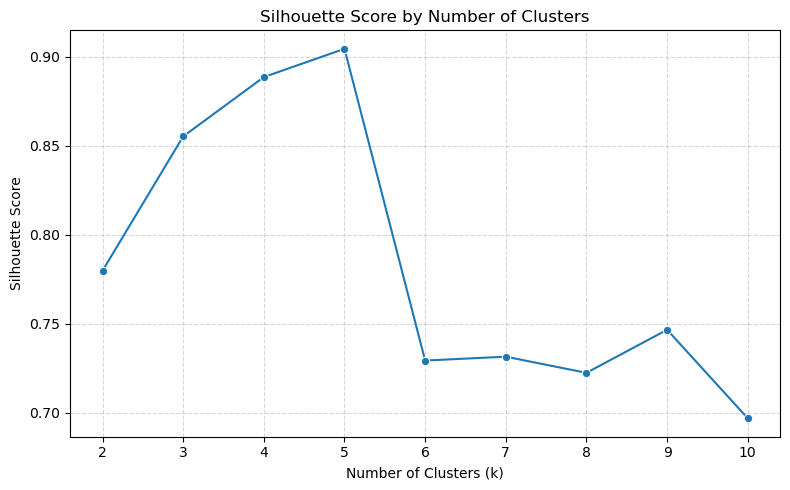

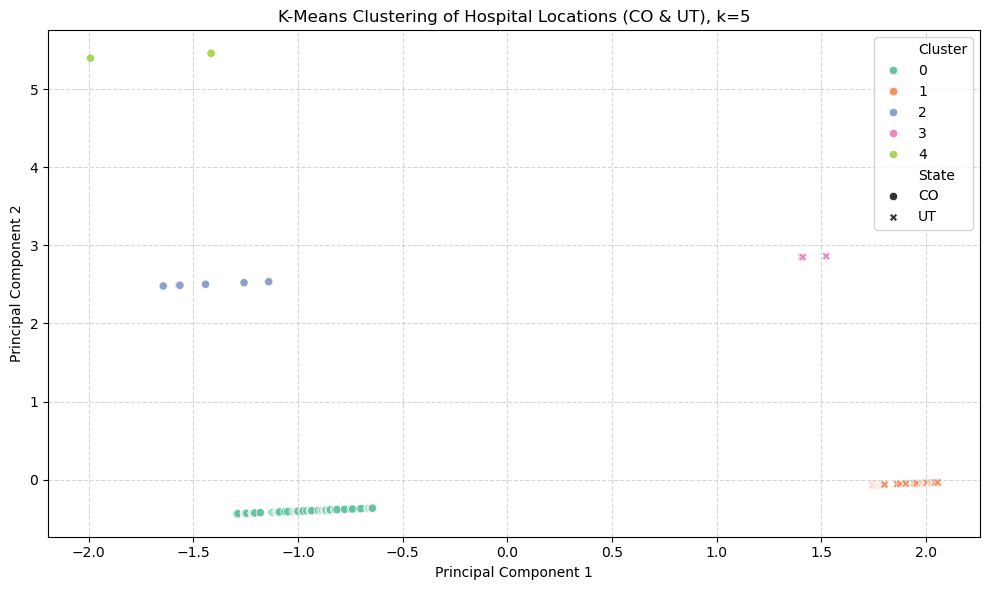

Final Silhouette Score (k=5): 0.904
Final Davies-Bouldin Index (k=5): 0.166


'1'

In [18]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL*")

# Prevent memory leak on Windows (MKL + KMeans)
os.environ['OMP_NUM_THREADS'] = '1'

# Display raw data
print('The data before processing are as follows:')
display(before_hospital_data)

# Load and filter hospital data for CO and UT
hospital_df = before_hospital_data.copy()
hospital_df = hospital_df.dropna(subset=['ZIP Code'])
hospital_df['ZIP_Code'] = hospital_df['ZIP Code'].astype(int)
hospital_df['State'] = hospital_df['State'].astype(str).str.upper()
hospital_df = hospital_df[hospital_df['State'].isin(['CO', 'UT'])]

# Aggregate hospital count per ZIP code
location_features = hospital_df.groupby(['State', 'ZIP_Code']).size().reset_index(name='Hospital_Count')

# One-hot encode 'State' and assemble features
features = pd.get_dummies(location_features[['State']], drop_first=True)
features['ZIP_Code'] = location_features['ZIP_Code']
features['Hospital_Count'] = location_features['Hospital_Count']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Show processed data
print('The data after processing are as follows:')
display(pd.DataFrame(X_scaled))

# Hyperparameter tuning: find best k using silhouette score
silhouette_scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append((k, score))

# Select best k
best_k, best_score = max(silhouette_scores, key=lambda x: x[1])

# Final KMeans clustering with best_k
kmeans = KMeans(n_clusters=best_k, random_state=42)
location_features['Cluster'] = kmeans.fit_predict(X_scaled)

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_scaled)
location_features['PCA1'] = reduced[:, 0]
location_features['PCA2'] = reduced[:, 1]

# Plot silhouette scores
score_df = pd.DataFrame(silhouette_scores, columns=['k', 'Silhouette_Score'])
plt.figure(figsize=(8, 5))
sns.lineplot(data=score_df, x='k', y='Silhouette_Score', marker='o')
plt.title('Silhouette Score by Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=location_features, x='PCA1', y='PCA2', hue='Cluster', style='State', palette='Set2')
plt.title(f'K-Means Clustering of Hospital Locations (CO & UT), k={best_k}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Evaluate clustering performance
final_labels = location_features['Cluster']
final_silhouette = silhouette_score(X_scaled, final_labels)
final_davies_bouldin = davies_bouldin_score(X_scaled, final_labels)

print(f"Final Silhouette Score (k={best_k}): {final_silhouette:.3f}")
print(f"Final Davies-Bouldin Index (k={best_k}): {final_davies_bouldin:.3f}")

# Clean up environment variable
os.environ.pop('OMP_NUM_THREADS', None)

**KMeans Clustering Summary**

- **Why chosen**: Suitable for uncovering structure in unlabeled ZIP-level hospital data (CO & UT).
- **Assumptions**: Numeric, standardized data; spherical and equally-sized clusters; predefined `k`.
- **Hyperparameter tuning**: Tried `k = 2–10`; selected `k = 5` using silhouette score (best score = **0.904**).
- **Challenges & solutions**:  
  - ZIP codes lack spatial meaning → used PCA with state & hospital count  
  - Windows MKL warning → set `OMP_NUM_THREADS = 1` and suppressed warnings
- **Evaluation Metrics**: Silhouette Score and Davies-Bouldin Index are used.
- **Data Formatting**: Features are scaled.

#### Model 2: Regression (Linear & Ridge)

- We will test whether it is possible to predict the number of hospitals (`Hospital_Count`) for each ZIP code from the ZIP code and state information.

In [19]:
# Regression analysis using LinearRegression and Ridge with hyperparameter tuning
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Display raw data
print('The data before processing are as follows:')
display(before_hospital_data)

# Prepare features from location_features
features_reg = pd.get_dummies(location_features[['State']], drop_first=True)
features_reg['ZIP_Code'] = location_features['ZIP_Code']
X = features_reg
y = location_features['Hospital_Count']

# Show processed data
print('The data after processing are as follows:')
display(pd.DataFrame(features_reg))

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train baseline Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

# Evaluate Linear Regression
linreg_mse = mean_squared_error(y_test, y_pred_lin)
linreg_rmse = np.sqrt(linreg_mse)
linreg_r2 = r2_score(y_test, y_pred_lin)

print('--- Linear Regression Results ---')
print(f'RMSE: {linreg_rmse:.3f}')
print(f'MSE: {linreg_mse:.3f}')
print(f'R²: {linreg_r2:.3f}')

# Ridge Regression with hyperparameter tuning
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Predict and evaluate
best_ridge = grid_search.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, y_pred_ridge)
best_alpha = grid_search.best_params_['alpha']

print('--- Ridge Regression Results ---')
print(f'Best alpha: {best_alpha}')
print(f'RMSE: {ridge_rmse:.3f}')
print(f'MSE: {ridge_mse:.3f}')
print(f'R²: {ridge_r2:.3f}')

The data before processing are as follows:


,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Telephone Number,Hospital Type,Hospital Ownership,...,Count of READM Measures Better,Count of READM Measures No Different,Count of READM Measures Worse,READM Group Footnote,Pt Exp Group Measure Count,Count of Facility Pt Exp Measures,Pt Exp Group Footnote,TE Group Measure Count,Count of Facility TE Measures,TE Group Footnote
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,...,1,8,2,NaN,8,8,NaN,12,10,NaN
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,...,0,8,1,NaN,8,8,NaN,12,12,NaN
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 629-1000,Acute Care Hospitals,Proprietary,...,0,7,2,NaN,8,8,NaN,12,11,NaN
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,...,0,7,0,NaN,8,8,NaN,12,7,NaN
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,...,0,2,0,NaN,8,Not Available,5.0,12,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5391,670323,ADVANCED ODESSA HOSPITAL & CLINICS,900 E 4TH ST,ODESSA,TX,79761,ECTOR,(713) 790-1666,Acute Care Hospitals,Physician,...,Not Available,Not Available,Not Available,5.0,Not Available,Not Available,5.0,Not Available,Not Available,5.0
5392,670326,BRUSHY CREEK FAMILY HOSPITAL LLC,230 DEER RIDGE DR,ROUND ROCK,TX,78681,WILLIAMSON,(512) 766-1400,Acute Care Hospitals,Proprietary,...,Not Available,Not Available,Not Available,19.0,Not Available,Not Available,19.0,Not Available,Not Available,19.0
5393,670327,EXCEPTIONAL COMMUNITY HOSPITAL LUBBOCK,6401 SPUR 327,LUBBOCK,TX,79424,LUBBOCK,(469) 341-7800,Acute Care Hospitals,Proprietary,...,Not Available,Not Available,Not Available,19.0,Not Available,Not Available,19.0,Not Available,Not Available,19.0
5394,671300,GRAHAM REGIONAL MEDICAL CENTER,1301 MONTGOMERY ROAD,GRAHAM,TX,76450,YOUNG,(940) 549-3400,Critical Access Hospitals,Government - Hospital District or Authority,...,Not Available,Not Available,Not Available,5.0,Not Available,Not Available,5.0,Not Available,Not Available,5.0


The data after processing are as follows:


,State_UT,ZIP_Code
0,False,80012
1,False,80021
2,False,80023
3,False,80026
4,False,80027
...,...,...
131,True,84721
132,True,84741
133,True,84751
134,True,84759


--- Linear Regression Results ---
RMSE: 0.304
MSE: 0.092
R²: 0.036
--- Ridge Regression Results ---
Best alpha: 1000
RMSE: 0.306
MSE: 0.093
R²: 0.024


**Regression Model Summary (Linear & Ridge)**

- **Why chosen**: Suitable for small, numeric, tabular data; Ridge helps prevent overfitting.
- **Assumptions**: Linearity, numeric input, homoscedasticity; Ridge assumes regularization improves generalization.
- **Hyperparameter tuning**: GridSearchCV used for Ridge (`alpha = 1000`).
- **Challenges & solutions**:  
  - Low R² → added Ridge regularization  
  - Limited features → used ZIP (numeric) + state (one-hot)
- **Evaluation Metrics**: RMSE, MSE, and $R^{2}$ are used.
- **Data formatting**: Categorical variables one-hot encoded; no scaling required for these models.

#### Model 3: Apriori Analysis

- What are the most common attribute patterns among the characteristics (type and ownership structure) of hospitals?

In [20]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Display raw data
print('The data before processing are as follows:')
display(before_hospital_data)

# Prepare data
hospital_df = before_hospital_data.copy()
hospital_df = hospital_df.dropna(subset=['Hospital Type', 'Hospital Ownership'])
hospital_df = hospital_df[hospital_df['State'].isin(['CO', 'UT'])]
transactions = hospital_df[['Hospital Type', 'Hospital Ownership']].astype(str).values.tolist()

# Transaction encoding
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# Show processed data
print('The data after processing are as follows:')
display(df_trans)

# Hyperparameter tuning grid
support_values = [0.01, 0.03, 0.05, 0.1]
lift_thresholds = [1.0, 1.2, 1.5]

# Search over combinations
results = []
for support in support_values:
    itemsets = apriori(df_trans, min_support=support, use_colnames=True)
    for lift_val in lift_thresholds:
        rules = association_rules(itemsets, metric='lift', min_threshold=lift_val)
        results.append({
            'min_support': support,
            'min_lift': lift_val,
            'num_rules': len(rules)
        })

# Display summary
summary_df = pd.DataFrame(results)
summary_df = summary_df.sort_values(by='num_rules', ascending=False)
display(summary_df)

The data before processing are as follows:


,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Telephone Number,Hospital Type,Hospital Ownership,...,Count of READM Measures Better,Count of READM Measures No Different,Count of READM Measures Worse,READM Group Footnote,Pt Exp Group Measure Count,Count of Facility Pt Exp Measures,Pt Exp Group Footnote,TE Group Measure Count,Count of Facility TE Measures,TE Group Footnote
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,...,1,8,2,NaN,8,8,NaN,12,10,NaN
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,...,0,8,1,NaN,8,8,NaN,12,12,NaN
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 629-1000,Acute Care Hospitals,Proprietary,...,0,7,2,NaN,8,8,NaN,12,11,NaN
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,...,0,7,0,NaN,8,8,NaN,12,7,NaN
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,...,0,2,0,NaN,8,Not Available,5.0,12,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5391,670323,ADVANCED ODESSA HOSPITAL & CLINICS,900 E 4TH ST,ODESSA,TX,79761,ECTOR,(713) 790-1666,Acute Care Hospitals,Physician,...,Not Available,Not Available,Not Available,5.0,Not Available,Not Available,5.0,Not Available,Not Available,5.0
5392,670326,BRUSHY CREEK FAMILY HOSPITAL LLC,230 DEER RIDGE DR,ROUND ROCK,TX,78681,WILLIAMSON,(512) 766-1400,Acute Care Hospitals,Proprietary,...,Not Available,Not Available,Not Available,19.0,Not Available,Not Available,19.0,Not Available,Not Available,19.0
5393,670327,EXCEPTIONAL COMMUNITY HOSPITAL LUBBOCK,6401 SPUR 327,LUBBOCK,TX,79424,LUBBOCK,(469) 341-7800,Acute Care Hospitals,Proprietary,...,Not Available,Not Available,Not Available,19.0,Not Available,Not Available,19.0,Not Available,Not Available,19.0
5394,671300,GRAHAM REGIONAL MEDICAL CENTER,1301 MONTGOMERY ROAD,GRAHAM,TX,76450,YOUNG,(940) 549-3400,Critical Access Hospitals,Government - Hospital District or Authority,...,Not Available,Not Available,Not Available,5.0,Not Available,Not Available,5.0,Not Available,Not Available,5.0


The data after processing are as follows:


,Acute Care - Department of Defense,Acute Care - Veterans Administration,Acute Care Hospitals,Childrens,Critical Access Hospitals,Department of Defense,Government - Hospital District or Authority,Government - Local,Government - State,Proprietary,Psychiatric,Veterans Health Administration,Voluntary non-profit - Church,Voluntary non-profit - Other,Voluntary non-profit - Private
0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
3,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
4,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False
145,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False
146,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False
147,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False


,min_support,min_lift,num_rules
0,0.01,1.0,22
1,0.01,1.2,18
2,0.01,1.5,14
3,0.03,1.0,12
4,0.03,1.2,10
6,0.05,1.0,8
5,0.03,1.5,6
7,0.05,1.2,6
9,0.10,1.0,6
8,0.05,1.5,4


**Apriori Analysis Summary**

- **Why chosen**: Ideal for discovering frequent patterns in categorical data (`Hospital Type`, `Ownership`).
- **Assumptions**: Requires binary, one-hot encoded transactions; assumes frequent subsets imply frequent supersets.
- **Hyperparameter tuning**: Grid search on `min_support` and `lift` to balance rule quantity and relevance.
- **Challenges & solutions**:  
  - Raw data not suitable → applied `TransactionEncoder`  
  - Too many weak rules → filtered with support/lift thresholds
- **Evaluation**: Rules assessed using **Support**, **Confidence**, and **Lift**; sorted by **Lift**.
- **Data formatting**: Converted attributes to one-hot transactions for Apriori compatibility.

#### Model 4: Random Forest

- Predicting a specific class based on the attributes of a hospital.

In [21]:
# Classification using Random Forest with hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Display raw data
print('The data before processing are as follows:')
display(before_hospital_data)

# Prepare data
hospital_df = before_hospital_data.copy()
hospital_df = hospital_df.dropna(subset=['Hospital Type', 'Hospital Ownership'])
hospital_df = hospital_df[hospital_df['State'].isin(['CO', 'UT'])]
hospital_df['Count of MORT Measures Better'] = pd.to_numeric(
    hospital_df['Count of MORT Measures Better'].replace('Not Available', pd.NA), errors='coerce')
hospital_df['Count of READM Measures Better'] = pd.to_numeric(
    hospital_df['Count of READM Measures Better'].replace('Not Available', pd.NA), errors='coerce')

# Select and clean relevant columns
columns_used = [
    'Hospital Type',
    'Hospital Ownership',
    'Count of MORT Measures Better',
    'Count of READM Measures Better'
]

hospital_data_cls = hospital_df[columns_used].dropna()

# Encode target variable
label_encoder = LabelEncoder()
y_cls = label_encoder.fit_transform(hospital_data_cls['Hospital Ownership'])

# One-hot encode categorical features
X_cls = pd.get_dummies(hospital_data_cls.drop(columns=['Hospital Ownership']))

# Show processed data
print('The data after processing are as follows:')
print('X_cls')
display(pd.DataFrame(X_cls))
print('y_cls')
display(pd.DataFrame(y_cls))

# Split into training and test sets
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

# Perform grid search with cross-validation
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=2,
    scoring='f1_weighted',
    n_jobs=-1
)
grid_search_rf.fit(X_train_cls, y_train_cls)

# Best model and predictions
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test_cls)

# Classification report
report = classification_report(
    y_test_cls,
    y_pred_best_rf,
    labels=label_encoder.transform(label_encoder.classes_),
    target_names=label_encoder.classes_,
    output_dict=True,
    zero_division=0 
)
report_df = pd.DataFrame(report).transpose()

# Show best parameters and performance
print('--- Best Random Forest Parameters ---')
display(grid_search_rf.best_params_)
print('\n--- Classification Report ---')
display(report_df[['precision', 'recall', 'f1-score']])

The data before processing are as follows:


,Facility ID,Facility Name,Address,City/Town,State,ZIP Code,County/Parish,Telephone Number,Hospital Type,Hospital Ownership,...,Count of READM Measures Better,Count of READM Measures No Different,Count of READM Measures Worse,READM Group Footnote,Pt Exp Group Measure Count,Count of Facility Pt Exp Measures,Pt Exp Group Footnote,TE Group Measure Count,Count of Facility TE Measures,TE Group Footnote
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,...,1,8,2,NaN,8,8,NaN,12,10,NaN
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,...,0,8,1,NaN,8,8,NaN,12,12,NaN
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 629-1000,Acute Care Hospitals,Proprietary,...,0,7,2,NaN,8,8,NaN,12,11,NaN
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,...,0,7,0,NaN,8,8,NaN,12,7,NaN
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,...,0,2,0,NaN,8,Not Available,5.0,12,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5391,670323,ADVANCED ODESSA HOSPITAL & CLINICS,900 E 4TH ST,ODESSA,TX,79761,ECTOR,(713) 790-1666,Acute Care Hospitals,Physician,...,Not Available,Not Available,Not Available,5.0,Not Available,Not Available,5.0,Not Available,Not Available,5.0
5392,670326,BRUSHY CREEK FAMILY HOSPITAL LLC,230 DEER RIDGE DR,ROUND ROCK,TX,78681,WILLIAMSON,(512) 766-1400,Acute Care Hospitals,Proprietary,...,Not Available,Not Available,Not Available,19.0,Not Available,Not Available,19.0,Not Available,Not Available,19.0
5393,670327,EXCEPTIONAL COMMUNITY HOSPITAL LUBBOCK,6401 SPUR 327,LUBBOCK,TX,79424,LUBBOCK,(469) 341-7800,Acute Care Hospitals,Proprietary,...,Not Available,Not Available,Not Available,19.0,Not Available,Not Available,19.0,Not Available,Not Available,19.0
5394,671300,GRAHAM REGIONAL MEDICAL CENTER,1301 MONTGOMERY ROAD,GRAHAM,TX,76450,YOUNG,(940) 549-3400,Critical Access Hospitals,Government - Hospital District or Authority,...,Not Available,Not Available,Not Available,5.0,Not Available,Not Available,5.0,Not Available,Not Available,5.0


The data after processing are as follows:
X_cls


,Count of MORT Measures Better,Count of READM Measures Better,Hospital Type_Acute Care - Veterans Administration,Hospital Type_Acute Care Hospitals,Hospital Type_Critical Access Hospitals
697,0.0,1.0,False,True,False
698,0.0,1.0,False,True,False
699,0.0,0.0,False,True,False
700,0.0,1.0,False,True,False
701,0.0,0.0,False,True,False
...,...,...,...,...,...
4855,0.0,2.0,False,True,False
4856,0.0,0.0,False,True,False
4862,0.0,0.0,False,False,True
4864,0.0,0.0,False,False,True


y_cls


,0
0,7
1,7
2,7
3,7
4,7
...,...
77,3
78,7
79,7
80,6


--- Best Random Forest Parameters ---


{'class_weight': 'balanced',
 'max_depth': None,
 'min_samples_split': 5,
 'n_estimators': 50}


--- Classification Report ---


,precision,recall,f1-score
Government - Hospital District or Authority,1.000000,1.000000,1.000000
Government - Local,0.000000,0.000000,0.000000
Government - State,0.111111,1.000000,0.200000
Proprietary,0.200000,0.250000,0.222222
Veterans Health Administration,0.000000,0.000000,0.000000
Voluntary non-profit - Church,0.000000,0.000000,0.000000
Voluntary non-profit - Other,0.000000,0.000000,0.000000
Voluntary non-profit - Private,0.000000,0.000000,0.000000
accuracy,0.176471,0.176471,0.176471
macro avg,0.163889,0.281250,0.177778


**Random Forest Classification Summary**

- **Why chosen**: Handles mixed data types and imbalanced classes well; robust and non-linear.
- **Assumptions**: Non-parametric; no assumptions on data distribution or linearity.
- **Hyperparameter tuning**: GridSearchCV on `n_estimators`, `max_depth`, `min_samples_split`, with `class_weight='balanced'`.
- **Challenges & solutions**:
  - Imbalanced classes → used `class_weight='balanced'`
  - Missing/invalid values → cleaned with `pd.to_numeric` and `dropna`
  - Unseen classes in test set → used `labels=` and `zero_division=0`
- **Evaluation metrics**: Precision, recall, F1-score (macro & weighted)
- **Data formatting**: One-hot encoding for categories; label encoding for target

#### Performance Evaluation

**Best Model for Comparing Colorado and Utah**
- **KMeans Clustering** is best aligned with the goal.  
  → It identifies geographic patterns in hospital distribution across ZIP codes, enabling structural comparison of facility availability between the two states.

**Other Models**
- **Linear/Ridge Regression**: Poor predictive power; not useful for comparison.  
- **Apriori**: Reveals ownership/type patterns, but not suitable for state-level comparison.  
- **Random Forest**: Good for prediction, but focuses on ownership classification, not availability.

**Conclusion**
- **KMeans** provides the most relevant insights for comparing the **distribution and concentration of hospitals** in Colorado and Utah.

### Health Insurance Data

#### Model 1: KMeans Clustering

- Based on the rate of non-insurance by ZIP code, areas are classified into groups with similar trends. This allows you to grasp the geographical characteristics of areas with many non-insured people and areas with few non-insured people.

The data before processing are as follows:


,NAME,B27010_001E,B27010_005E,ZIP_Code,Total_Population,Uninsured_Population,Uninsured_Rate
0,ZCTA5 00601,16791,129,00601,16791,129,0.768269
1,ZCTA5 00602,37575,393,00602,37575,393,1.045908
2,ZCTA5 00603,48355,480,00603,48355,480,0.992658
3,ZCTA5 00606,5590,0,00606,5590,0,0.000000
4,ZCTA5 00610,25446,175,00610,25446,175,0.687731
...,...,...,...,...,...,...,...
33769,ZCTA5 99923,25,0,99923,25,0,0.000000
33770,ZCTA5 99925,920,2,99925,920,2,0.217391
33771,ZCTA5 99926,1464,0,99926,1464,0,0.000000
33772,ZCTA5 99927,14,0,99927,14,0,0.000000


The data after processing are as follows:


,NAME,B27010_001E,B27010_005E,ZIP_Code,Total_Population,Uninsured_Population,Uninsured_Rate,Cluster,PCA1,PCA2
0,ZCTA5 00601,16791,129,00601,16791,129,0.768269,0,0.183216,-0.466885
1,ZCTA5 00602,37575,393,00602,37575,393,1.045908,1,1.256926,-1.373285
2,ZCTA5 00603,48355,480,00603,48355,480,0.992658,1,1.754392,-1.902840
3,ZCTA5 00606,5590,0,00606,5590,0,0.000000,0,-0.581834,-0.164805
4,ZCTA5 00610,25446,175,00610,25446,175,0.687731,1,0.571234,-0.903436
...,...,...,...,...,...,...,...,...,...,...
33769,ZCTA5 99923,25,0,99923,25,0,0.000000,0,-0.846926,0.100286
33770,ZCTA5 99925,920,2,99925,920,2,0.217391,0,-0.738790,0.123154
33771,ZCTA5 99926,1464,0,99926,1464,0,0.000000,0,-0.778378,0.031739
33772,ZCTA5 99927,14,0,99927,14,0,0.000000,0,-0.847450,0.100810


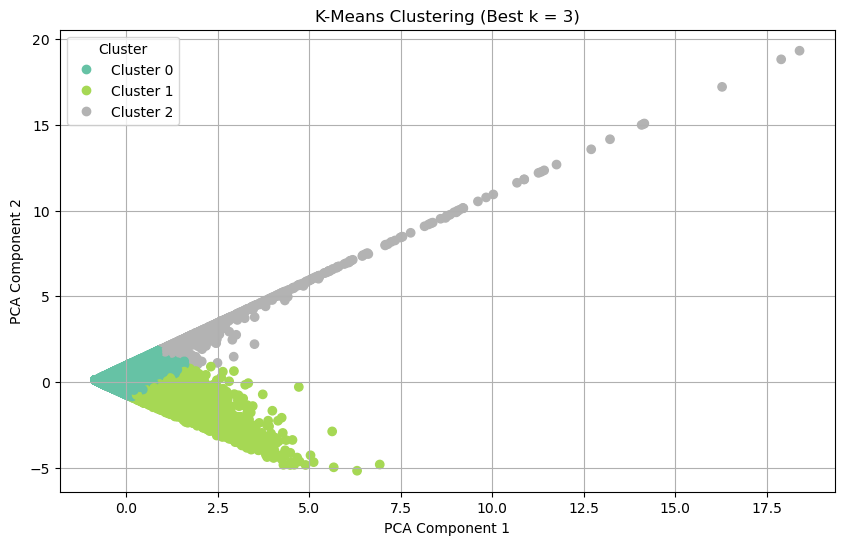

(   silhouette  db_index
 k                      
 2    0.593487  0.678806
 3    0.638666  0.589718
 4    0.638233  0.571288
 5    0.584762  0.618108
 6    0.581860  0.599748
 7    0.550502  0.631408,
    Cluster  Uninsured_Rate_mean  Uninsured_Rate_min  Uninsured_Rate_max  \
 0        0             0.871729            0.000000            5.905512   
 1        1             1.254131            0.000000            8.572570   
 2        2            10.931195            5.916586           63.829787   
 
    Total_Population_mean  Total_Population_min  Total_Population_max  \
 0            4065.600414                     1                 20867   
 1           36933.281271                 18967                133319   
 2            1440.743354                     3                 25404   
 
    ZIP_Code_count  
 0           26057  
 1            6012  
 2             978  )

In [40]:
# Display raw data
print('The data before processing are as follows:')
display(before_health_insurance_data)

# Load the insurance data
insurance_df = before_health_insurance_data.copy()

# Clean and select relevant features
X = insurance_df[['Uninsured_Rate', 'Total_Population']].dropna().copy()
X_scaled = StandardScaler().fit_transform(X)

# Hyperparameter tuning (searching best k)
k_range = range(2, 8)
scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette = silhouette_score(X_scaled, labels)
    db_index = davies_bouldin_score(X_scaled, labels)
    scores.append({'k': k, 'silhouette': silhouette, 'db_index': db_index})

# Find best k (maximize silhouette, minimize DB index)
scores_df = pd.DataFrame(scores)
best_k = scores_df.loc[scores_df['silhouette'].idxmax(), 'k']

# Final clustering with best_k
kmeans = KMeans(n_clusters=int(best_k), random_state=42)
labels = kmeans.fit_predict(X_scaled)
insurance_clustered = insurance_df.loc[X.index].copy()
insurance_clustered['Cluster'] = labels

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
insurance_clustered['PCA1'] = components[:, 0]
insurance_clustered['PCA2'] = components[:, 1]

# Show processed data
print('The data after processing are as follows:')
display(pd.DataFrame(insurance_clustered))

# Cluster summary statistics
cluster_summary = insurance_clustered.groupby('Cluster').agg({
    'Uninsured_Rate': ['mean', 'min', 'max'],
    'Total_Population': ['mean', 'min', 'max'],
    'ZIP_Code': 'count'
})
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary.reset_index(inplace=True)

# Plot with legend
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    insurance_clustered['PCA1'],
    insurance_clustered['PCA2'],
    c=insurance_clustered['Cluster'],
    cmap='Set2'
)
plt.title(f'K-Means Clustering (Best k = {int(best_k)})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)

# Add legend
handles, _ = scatter.legend_elements()
labels = [f"Cluster {i}" for i in range(int(best_k))]
plt.legend(handles, labels, title="Cluster")
plt.show()

# Show performance metrics and summary
scores_df.set_index('k'), cluster_summary

#### K-Means Clustering Summary

- **Why chosen**: Ideal for grouping unlabeled, numeric data (e.g., uninsured rate, population).
- **Assumptions**: Numeric, standardized features; spherical, equally sized clusters; predefined `k`.
- **Hyperparameter tuning**: Tested `k=2–7`; selected best `k` using silhouette score and Davies-Bouldin index.
- **Challenges & solutions**:  
  - Missing data → used `.dropna()`  
  - Index mismatch → aligned using `.loc[X.index]`  
  - Scaling required → applied `StandardScaler`
- **Evaluation**:  
  - **Silhouette Score** (↑ better separation)  
  - **Davies-Bouldin Index** (↓ less overlap)
- **Transformations**: Selected and standardized `Uninsured_Rate` & `Total_Population`.

#### Model 2: Regression (Linear & Ridge)

- We will examine whether it is possible to predict the uninsured rate (Uninsured Rate) from the total population (Total Population) for each ZIP code.

In [36]:
# Display raw data
print('The data before processing are as follows:')
display(before_health_insurance_data)

# Load the insurance data
insurance_df = before_health_insurance_data.copy()

# Prepare features
regression_df = insurance_df[['Uninsured_Rate', 'Total_Population']].dropna().copy()
X = regression_df[['Total_Population']]
y = regression_df['Uninsured_Rate']

# Show processed data
print('The data after processing are as follows:')
display(pd.DataFrame(regression_df))

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------
# Linear Regression
# ----------------------
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

linreg_mse = mean_squared_error(y_test, y_pred_lin)
linreg_rmse = np.sqrt(linreg_mse)
linreg_r2 = r2_score(y_test, y_pred_lin)

print("\n--- Linear Regression Results ---")
print(f"RMSE: {linreg_rmse:.3f}")
print(f"MSE: {linreg_mse:.3f}")
print(f"R²: {linreg_r2:.6f}")

# ----------------------
# Ridge Regression with Hyperparameter Tuning
# ----------------------
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_ridge = grid_search.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, y_pred_ridge)
best_alpha = grid_search.best_params_['alpha']

print("\n--- Ridge Regression Results ---")
print(f"Best alpha: {best_alpha}")
print(f"RMSE: {ridge_rmse:.3f}")
print(f"MSE: {ridge_mse:.3f}")
print(f"R²: {ridge_r2:.6f}")

The data before processing are as follows:


,NAME,B27010_001E,B27010_005E,ZIP_Code,Total_Population,Uninsured_Population,Uninsured_Rate
0,ZCTA5 00601,16791,129,00601,16791,129,0.768269
1,ZCTA5 00602,37575,393,00602,37575,393,1.045908
2,ZCTA5 00603,48355,480,00603,48355,480,0.992658
3,ZCTA5 00606,5590,0,00606,5590,0,0.000000
4,ZCTA5 00610,25446,175,00610,25446,175,0.687731
...,...,...,...,...,...,...,...
33769,ZCTA5 99923,25,0,99923,25,0,0.000000
33770,ZCTA5 99925,920,2,99925,920,2,0.217391
33771,ZCTA5 99926,1464,0,99926,1464,0,0.000000
33772,ZCTA5 99927,14,0,99927,14,0,0.000000


The data after processing are as follows:


,Uninsured_Rate,Total_Population
0,0.768269,16791
1,1.045908,37575
2,0.992658,48355
3,0.000000,5590
4,0.687731,25446
...,...,...
33769,0.000000,25
33770,0.217391,920
33771,0.000000,1464
33772,0.000000,14



--- Linear Regression Results ---
RMSE: 2.338
MSE: 5.465
R²: 0.000001

--- Ridge Regression Results ---
Best alpha: 1000
RMSE: 2.338
MSE: 5.465
R²: 0.000001


#### Linear & Ridge Regression Summary

- **Why chosen**: To test if `Total_Population` can explain `Uninsured_Rate` using a simple numeric model.
- **Assumptions**: Linearity, homoscedasticity, normal residuals; Ridge adds L2 regularization.
- **Hyperparameter tuning**: Ridge tuned via `GridSearchCV`; best `alpha = 1000`, no performance gain.
- **Challenges & solutions**:
  - Very low R² → Ridge applied, but still ineffective
  - Only one feature → suggested adding more variables
- **Evaluation**: Used RMSE, MSE, and R² (all showed weak model fit).
- **Data prep**: Used `.dropna()`; standardization not needed.

#### Model 3: Decision Tree Classification

- Classifies and predicts whether the uninsured rate (Uninsured Rate) in a given area is high or low, based on the population (Total_Population) by ZIP code.

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import KBinsDiscretizer

# Display raw data
print('The data before processing are as follows:')
display(before_health_insurance_data)

# Copy and clean data
insurance_df = before_health_insurance_data.copy()
cls_df = insurance_df[['Uninsured_Rate', 'Total_Population']].dropna().copy()

# Convert Uninsured Rate into binary target (high vs low)
# NOTE: 'strategy' should be 'quantile', not 'median'
binner = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='quantile')
cls_df['Uninsured_High'] = binner.fit_transform(cls_df[['Uninsured_Rate']]).astype(int)

# Show processed data
print('The data after processing are as follows:')
display(cls_df)

# Prepare input and target
X_cls = cls_df[['Total_Population']]
y_cls = cls_df['Uninsured_High']
X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

# Set up Decision Tree with GridSearchCV
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1'
)
grid_search.fit(X_train, y_train)

# Evaluate best model
best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Display results
print('Best Parameters:', grid_search.best_params_)
print('\n--- Classification Report ---')
print(report_df[['precision', 'recall', 'f1-score']])

The data before processing are as follows:


,NAME,B27010_001E,B27010_005E,ZIP_Code,Total_Population,Uninsured_Population,Uninsured_Rate
0,ZCTA5 00601,16791,129,00601,16791,129,0.768269
1,ZCTA5 00602,37575,393,00602,37575,393,1.045908
2,ZCTA5 00603,48355,480,00603,48355,480,0.992658
3,ZCTA5 00606,5590,0,00606,5590,0,0.000000
4,ZCTA5 00610,25446,175,00610,25446,175,0.687731
...,...,...,...,...,...,...,...
33769,ZCTA5 99923,25,0,99923,25,0,0.000000
33770,ZCTA5 99925,920,2,99925,920,2,0.217391
33771,ZCTA5 99926,1464,0,99926,1464,0,0.000000
33772,ZCTA5 99927,14,0,99927,14,0,0.000000


The data after processing are as follows:


,Uninsured_Rate,Total_Population,Uninsured_High
0,0.768269,16791,1
1,1.045908,37575,1
2,0.992658,48355,1
3,0.000000,5590,0
4,0.687731,25446,1
...,...,...,...
33769,0.000000,25,0
33770,0.217391,920,0
33771,0.000000,1464,0
33772,0.000000,14,0


Best Parameters: {'max_depth': 2, 'min_samples_split': 2}

--- Classification Report ---
              precision    recall  f1-score
0              0.701447  0.548377  0.615539
1              0.619227  0.758843  0.681963
accuracy       0.651891  0.651891  0.651891
macro avg      0.660337  0.653610  0.648751
weighted avg   0.661009  0.651891  0.648208


#### Decision Tree Classification Summary

- **Why chosen**: Suitable for small, tabular data; interpretable and handles numeric input directly.
- **Assumptions**: No assumptions on feature distribution or linearity.
- **Hyperparameter tuning**: `max_depth` and `min_samples_split` tuned via GridSearchCV (5-fold, F1-score).
- **Challenges & solutions**:  
  - Created binary target with `KBinsDiscretizer`  
  - Tuned tree depth to avoid overfitting
- **Evaluation**: Used precision, recall, and F1-score.
- **Transformations**: Binned `Uninsured_Rate`; used `Total_Population` directly.


#### Model 4: Apriori Analysis

- Based on the uninsured rate and total population for each ZIP code, we extract the most common combination patterns.

In [38]:
# Display raw data
print('The data before processing are as follows:')
display(before_health_insurance_data)

# Copy and clean data
insurance_df = before_health_insurance_data.copy()

# Discretize Uninsured_Rate and Total_Population
bins_rate = [0, 5, 10, 100]
labels_rate = ['Low_Uninsured', 'Medium_Uninsured', 'High_Uninsured']
insurance_df['Uninsured_Level'] = pd.cut(insurance_df['Uninsured_Rate'], bins=bins_rate, labels=labels_rate)

bins_pop = [0, 10000, 50000, 200000]
labels_pop = ['Small_Pop', 'Medium_Pop', 'Large_Pop']
insurance_df['Population_Level'] = pd.cut(insurance_df['Total_Population'], bins=bins_pop, labels=labels_pop)

# Create transactions from discretized values
pattern_df = insurance_df[['Uninsured_Level', 'Population_Level']].dropna()
transactions = pattern_df.values.tolist()

# One-hot encode transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# Show processed data
print('The data after processing are as follows:')
display(df_trans)

# Hyperparameter tuning over support and lift
support_vals = [0.01, 0.03, 0.05, 0.1]
lift_vals = [1.0, 1.2, 1.5]
results = []

for support in support_vals:
    itemsets = apriori(df_trans, min_support=support, use_colnames=True)
    for lift in lift_vals:
        rules = association_rules(itemsets, metric='lift', min_threshold=lift)
        results.append({
            'min_support': support,
            'min_lift': lift,
            'num_rules': len(rules)
        })

# Display tuning results
results_df = pd.DataFrame(results).sort_values(by='num_rules', ascending=False)
print("\n--- Hyperparameter Tuning Summary ---")
print(results_df)

# Apply best combination (or one with reasonable rules)
best_support = results_df.iloc[0]['min_support']
best_lift = results_df.iloc[0]['min_lift']
final_itemsets = apriori(df_trans, min_support=best_support, use_colnames=True)
final_rules = association_rules(final_itemsets, metric='lift', min_threshold=best_lift)
final_rules_sorted = final_rules.sort_values(by='lift', ascending=False)

# Show top rules
print("\n--- Top Association Rules ---")
print(final_rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

The data before processing are as follows:


,NAME,B27010_001E,B27010_005E,ZIP_Code,Total_Population,Uninsured_Population,Uninsured_Rate
0,ZCTA5 00601,16791,129,00601,16791,129,0.768269
1,ZCTA5 00602,37575,393,00602,37575,393,1.045908
2,ZCTA5 00603,48355,480,00603,48355,480,0.992658
3,ZCTA5 00606,5590,0,00606,5590,0,0.000000
4,ZCTA5 00610,25446,175,00610,25446,175,0.687731
...,...,...,...,...,...,...,...
33769,ZCTA5 99923,25,0,99923,25,0,0.000000
33770,ZCTA5 99925,920,2,99925,920,2,0.217391
33771,ZCTA5 99926,1464,0,99926,1464,0,0.000000
33772,ZCTA5 99927,14,0,99927,14,0,0.000000


The data after processing are as follows:


,High_Uninsured,Large_Pop,Low_Uninsured,Medium_Pop,Medium_Uninsured,Small_Pop
0,False,False,True,True,False,False
1,False,False,True,True,False,False
2,False,False,True,True,False,False
3,False,False,True,True,False,False
4,False,True,True,False,False,False
...,...,...,...,...,...,...
23157,False,False,True,False,False,True
23158,False,False,True,True,False,False
23159,False,False,True,False,False,True
23160,False,False,True,False,False,True



--- Hyperparameter Tuning Summary ---
    min_support  min_lift  num_rules
0          0.01       1.0          8
3          0.03       1.0          6
1          0.01       1.2          4
2          0.01       1.5          4
4          0.03       1.2          2
5          0.03       1.5          2
6          0.05       1.0          2
9          0.10       1.0          2
7          0.05       1.2          0
8          0.05       1.5          0
10         0.10       1.2          0
11         0.10       1.5          0

--- Top Association Rules ---
          antecedents         consequents   support  confidence      lift
0         (Small_Pop)    (High_Uninsured)  0.015240    0.026115  1.699106
1    (High_Uninsured)         (Small_Pop)  0.015240    0.991573  1.699106
6         (Small_Pop)  (Medium_Uninsured)  0.038857    0.066583  1.604778
7  (Medium_Uninsured)         (Small_Pop)  0.038857    0.936524  1.604778
2         (Large_Pop)     (Low_Uninsured)  0.041231    0.994792  1.054766
3    

#### Apriori Analysis Summary

- **Why chosen**: Best for discovering frequent patterns in binned insurance and population data.
- **Assumptions**: One-hot encoded categorical inputs; assumes frequent subsets imply frequent supersets.
- **Hyperparameter tuning**: Tuned `min_support` and `min_lift` to balance rule quantity and strength.
- **Challenges & solutions**:
  - Numeric input → discretized into bins  
  - Too few/many rules → tuned thresholds
- **Evaluation metrics**: Support, Confidence, Lift (used to rank rules).
- **Data transformation**: Binned `Uninsured_Rate` & `Total_Population`, then one-hot encoded for Apriori.

#### Performance Evaluation

**Best Model for Comparing Colorado and Utah**

- **KMeans Clustering** was the most effective model for comparing healthcare facility availability.  
    - It grouped ZIP codes based on `Uninsured_Rate` and `Total_Population`, revealing clear spatial patterns and disparities.  
    - The high silhouette score indicated strong, well-separated clusters—ideal for understanding regional healthcare access.

**Other Models**

- **Linear & Ridge Regression**: Very low R² (~0); population did not explain uninsured rate.
- **Decision Tree Classification**: Moderate performance after tuning, but limited by use of only one feature.
- **Apriori Analysis**: Provided interpretable rules on co-occurring attributes (e.g., high uninsured + small population), useful for pattern exploration, not prediction.

**Conclusion**

- **KMeans** best supported the goal of identifying differences in facility availability across regions.  
- Other models added interpretive or predictive insights but were limited by data structure or weak signal strength.